# bayes rule

#### $$P(A|B) = \frac {P(B|A)P(A)}{P(B)}$$

In [11]:
pA = 0.06 # probability of rare event
pB = 0.26 # probability of precursor event
pBA = 1.0

pAB = (pBA*pA)/pB

print('Posterior p(A|B) = {}'.format(pAB))

Posterior p(A|B) = 0.23076923076923075


# [Example 1](https://www.datascience.com/blog/introduction-to-bayesian-inference-learn-data-science-tutorials)

Assume that we run an ecommerce platform for clothing and in order to bring people to our site, we deploy several digital marketing campaigns. These campaigns feature various ad images and captions, and are presented on a number of social networking websites. We want to present the ads that are the most successful. For the sake of simplicity, we can assume that the most successful campaign is the one that results in the highest click-through rate: the ads that are most likely to be clicked if shown.

We introduce a new campaign called "facebook-yellow-dress," a campaign presented to Facebook users featuring a yellow dress. The ad has been presented to 10 users so far, and 7 of the users have clicked on it. We would like to estimate the probability that the next user will click on the ad. 

By encoding a click as a success and a non-click as a failure, we're estimating the probability θ that a given user will click on the ad. Naturally, we are going to use the campaign's historical record as evidence. Because we are considering unordered draws of an event that can be either 0 or 1, we can infer the probability θ by considering the campaign's history as a sample from a binomial distribution, with probability of success θ. Traditional approaches of inference consider multiple values of θ and pick the value that is most aligned with the data. This is known as maximum likelihood, because we're evaluating how likely our data is under various assumptions and choosing the best assumption as true. More formally:

 argmaxθp(X |θ), where X is the data we've observed.

Here, p(X |θ) is our likelihood function; if we fix the parameter θ, what is the probability of observing the data we've seen? Let's look at the likelihood of various values of θ given the data we have for facebook-yellow-dress:

In [35]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,7)

In [36]:
def likelihood(theta, n, x):
    """
    likelihood function for a binomial distribution

    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    """
    return (factorial(n) / (factorial(x) * factorial(n - x))) \
            * (theta ** x) * ((1 - theta) ** (n - x))

In [80]:
#the number of impressions for our facebook-yellow-dress campaignn_impressions = 10.
n_impressions = 10

#the number of clicks for our facebook-yellow-dress campaign
n_clicks = 7

#observed click through rate
ctr = n_clicks / n_impressions

#0 to 1, all possible click through rates
possible_theta_values = np.arange(0.01,1.0,0.01)

#evaluate the likelihood function for possible click through rates
likelihoods = list(map(lambda theta: likelihood(theta, n_impressions, n_clicks), possible_theta_values))

#pick the best theta
mle = possible_theta_values[np.argmax(likelihoods)]

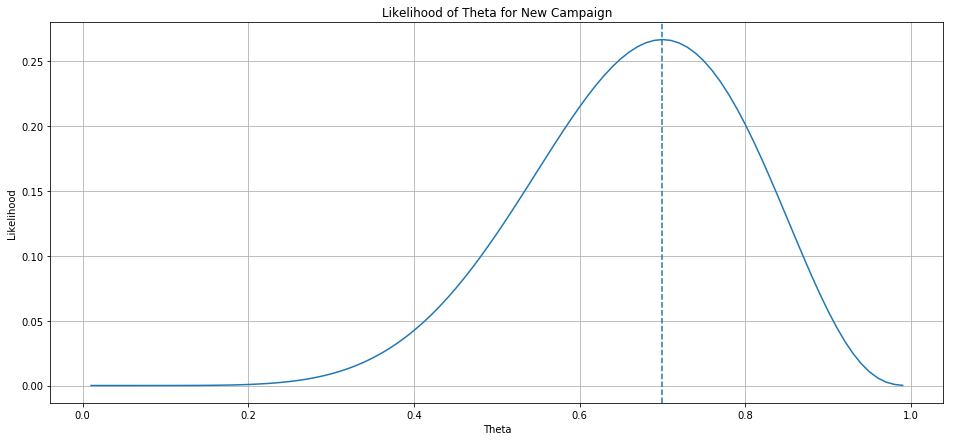

In [81]:
#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.axvline(mle, linestyle = "--")

ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Likelihood of Theta for New Campaign")
plt.show()

Of the 10 people we showed the new ad to, 7 of them clicked on it. So naturally, our likelihood function is telling us that the most likely value of theta is 0.7. However, some of our analysts are skeptical. The performance of this campaign seems extremely high given how our other campaigns have done historically. Let's overlay this likelihood function with the distribution of click-through rates from our previous 100 campaigns:

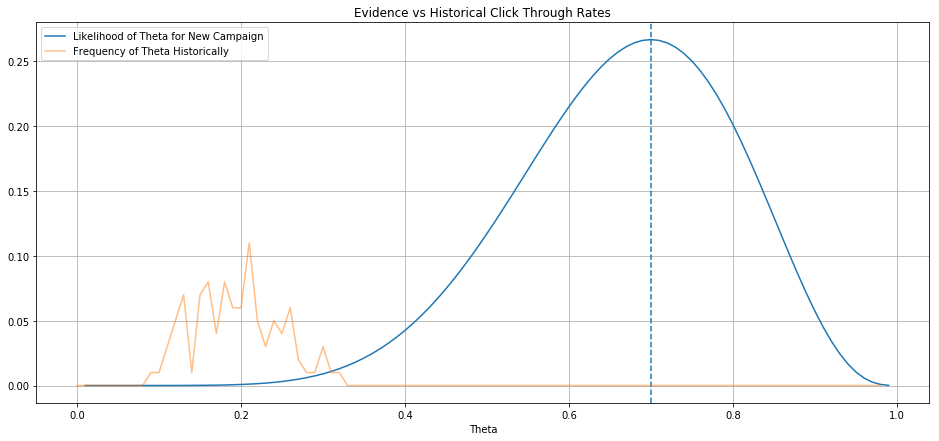

In [94]:
plt.rcParams['figure.figsize'] = (16, 7)
import numpy as np
import pandas as pd

true_a = 11.5
true_b = 48.5

#number of marketing campaigns
N = 100

#randomly generate "true" click through rate for each campaign
p = np.random.beta(true_a,true_b, size=N)

#randomly pick the number of impressions for each campaign
impressions = np.random.randint(1, 10000, size=N)

#sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p).astype(float)
click_through_rates = clicks / impressions

#plot the histogram of previous click through rates with the evidence#of the new campaign
f, ax = plt.subplots(1)
ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, likelihoods)

zero_to_one = np.arange(0.0,1.0,0.01)
counts, bins = np.histogram(click_through_rates, bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for New Campaign'
                           , 'Frequency of Theta Historically')
                          , loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Evidence vs Historical Click Through Rates")
plt.show()

Clearly, the maximum likelihood method is giving us a value that is outside what we would normally see. Perhaps our analysts are right to be skeptical; as the campaign continues to run, its click-through rate could decrease. Alternatively, this campaign could be truly outperforming all previous campaigns. We can't be sure. Ideally, we would rely on other campaigns' history if we had no data from our new campaign. And as we got more and more data, we would allow the new campaign data to speak for itself.

### [Beta](https://stats.stackexchange.com/a/47782/100439)
For our example, because we have related data and limited data on the new campaign, we will use an informative, empirical prior. We will choose a beta distribution for our prior for θ. The beta distribution is a 2 parameter (α, β) distribution that is often used as a prior for the θ parameter of the binomial distribution. Because we want to use our previous campaigns as the basis for our prior beliefs, we will determine α and β by fitting a beta distribution to our historical click-through rates. Below, we fit the beta distribution and compare the estimated prior distribution with previous click-through rates to ensure the two are properly aligned:

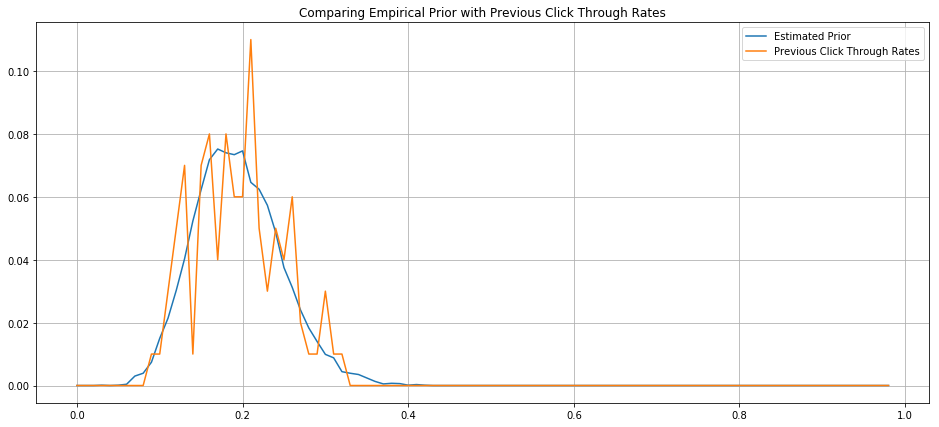

In [106]:
from scipy.stats import beta

#fit beta to previous CTRs
prior_parameters = beta.fit(click_through_rates
                            , floc = 0
                            , fscale = 1)

#extract a,b from fit
prior_a, prior_b = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)

#get histogram of samples
prior_samples = prior_distribution.rvs(10000)

#get histogram of samples
fit_counts, bins = np.histogram(prior_samples, zero_to_one)

#normalize histogram
fit_counts = [x/fit_counts.sum() for x in fit_counts]

#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)

hist_ctr, bins = np.histogram(click_through_rates, zero_to_one)
hist_ctr = [x/hist_ctr.sum() for x in hist_ctr]

ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates)
          ,('Estimated Prior', 'Previous Click Through Rates'))

ax.grid()
ax.set_title("Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

### The priors
We find that the best values of α and β are 11.5 and 48.5, respectively. The beta distribution with these parameters does a good job capturing the click-through rates from our previous campaigns, so we will use it as our prior. We will now update our prior beliefs with the data from the facebook-yellow-dress campaign to form our posterior distribution.

### The Posterior Distribution

After considering the 10 impressions of data we have for the facebook-yellow-dress campaign, the posterior distribution of θ gives us plausibility of any click-through rate from 0 to 1.

The effect of our data, or our evidence, is provided by the likelihood function, p(X|θ). What we are ultimately interested in is the plausibility of all proposed values of θ given our data or our posterior distribution p(θ|X). From the earlier section introducing Bayes' Theorem, our posterior distribution is given by the product of our likelihood function and our prior distribution:

$ p(\theta | X) = \frac{p(\theta) p(X | \theta)}{p(X)} $

Since p(X) is a constant, as it does not depend on θ, we can think of the posterior distribution as:

$\text{Posterior} = \frac{\text{Prior}\cdot\text{Evidence}}{\text{Constant}}$

We'll now demonstrate how to estimate p(θ|X) using PyMC.

Usually, the true posterior must be approximated with numerical methods. To see why, let's return to the definition of the posterior distribution:

$ p(\theta | X) = \frac{p(\theta) p(X | \theta)}{p(X)} $

The denominator p(X) is the total probability of observing our data under all possible values of θ. A more descriptive representation of this quantity is given by:

$\int p(\theta) p(X|\theta) d\theta$

Which sums the probability of X over all values of θ. This integral usually does not have a closed-form solution, so we need an approximation. One method of approximating our posterior is by using Markov Chain Monte Carlo (MCMC), which generates samples in a way that mimics the unknown distribution. We begin at a particular value, and "propose" another value as a sample according to a stochastic process. We may reject the sample if the proposed value seems unlikely and propose another. If we accept the proposal, we move to the new value and propose another.

PyMC is a python package for building arbitrary probability models and obtaining samples from the posterior distributions of unknown variables given the model. In our example, we'll use MCMC to obtain the samples.

The prototypical PyMC program has two components:

    Define all variables, and how variables depend on each other
    Run an algorithm to simulate a posterior distribution

Let's now obtain samples from the posterior. We select our prior as a Beta(11.5,48.5). Let's see how observing 7 clicks from 10 impressions updates our beliefs: